# ACF

```cpp
acf(amplitude_probes& amp, unsigned int W);
```
Конструктор класса ACF, он параметризован:
* **W** -- размер окна свертки
* **amp** -- ссылка на класс **amplitude_probes**, который содержит снятые показания амплитуд

``` cpp
double at(unsigned int time, unsigned int lag);
```
Вычисляет $r_{time}(lag)$ 

# Difference function
``` cpp
std::vector <double> diff(amplitude_probes& A, unsigned int time, acf& ACF);
```
* **A**  -- ссылка на показания амплитуд
* **time** -- момент времени для которого вычисляется разностная функция
* **ACF** -- ссылка на параметризованную acf

## Расчет
Значение функции $d_t(\tau)$ нужно вычислить в каждый момент времени и для каждого сдвига (ограничиваясь максимальным периодом, который нужно распознать). Это делается последовательно.
* В момент времени t = 0 (режим холодного старта) 

 $d_0(\tau)$ вычисляется с помощью трех слагаемых ACF:
 $$d_t(\tau) = r_t(0) + r_{t+\tau}(0) - 2r_t(\tau)$$
 
 1. $r_t(0)$ не зависит от $\tau$ и может быть посчитано вне цикла
 2. $r_{t+\tau}(0)$ позволяет воспользовать рекурсией по "нижнему индексу", а потому может быть вычислена итеративно:
 $$
     r_{t+\tau}(0) =  r_{t + (\tau - 1)}(0) + x(t+\tau + W)^2 - x(t+\tau)^2
 $$
 3. $r_t(\tau)$ считается с помощью вызова ACF.at()
* В момент времени t, если известная разностная функция для момент t-1

 Поскольку
 $$
   d_t(\tau) = r_t(0) + r_{t+\tau}(0) - 2r_t(\tau) 
 $$
 То
 $$
     d_t(\tau) = d_{t-1}(\tau)  + t_1 + t_2 - 2  t_3
 $$
 Где
 $$
 t_1 = r_t(0) - r_{t-1}(0) = x(t+W)^2 - x(t)^2\\
 t_2 = r_{t+\tau}(0) - r_{t-1+\tau}(0) = x(t+\tau+W)x(t+\tau+W) - x(t+\tau)x(t+\tau);\\
 t_3 = r_{t}(\tau) - r_{t-1}(\tau) = x(t+\tau+W)x(t+W) - x(t) x(t+\tau);
 $$
 

 # IIR Filter

IIR фильтр реализован с помощью каскадного соединения фильтров второго порядка (biquad). Фильтрация осуществляется последовательным применением biquad.apply

Фильтр второго порядка представлен в Transposed Form II, которая [считается](http://www.earlevel.com/main/2003/02/28/biquads/) наиболее приемлимой для float.
![Transposed Form II](https://ccrma.stanford.edu/~jos/fp/img1144.png)

У класса **biquad** члены **z1** и **z2** выполняют функцию временных регистров, которые задерживают сигнал. 

```cpp
biquad (std::ifstream& file);
```
Функция считывает коэффициенты секции (числитель и знаменатель) из файла *file*. В этом файле должны хранится коэффициенты каскадов, он генерируется скриптом *filter.py*. Файл coef **ОБЯЗАТЕЛЬНО** должен быть создан (и заполнен соотвественно) перед использованием программы.

## Пример использования фильтра
В *filter.py* примерно такие же настройки

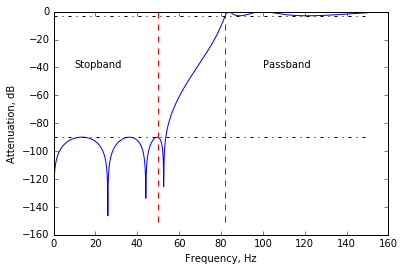

In [92]:
from scipy.signal import filter_design as fd
from numpy import log10, abs, argmax, arange, sin
from scipy.signal import freqz,lfilter
from math import pi
from matplotlib import pyplot as plt
import numpy.random

# Specification for our filter
F_S = 8000
F_NY = F_S/2 # Nyquist frequency
Fp = 82
Fs = 50
Wp = Fp/F_NY # end of passband, normalized frequency
Ws = Fs/F_NY # start of the stopband, normalized frequency 
Rp = 3    # passband maximum loss (gpass)
As = 90      # stoppand min attenuation (gstop)

# The ellip filter design
# output='ba' 'cause we need that form for freqz
b, a = fd.iirdesign(Wp, Ws, Rp, As, ftype='ellip', output = 'ba')

(w, H) = freqz(b,a, worN=6*10**4)

Hn = 20 * log10(abs(H))
freq = w / (2*pi) * F_S
lim = argmax(freq > 150)
ylim = min(Hn)
plt.plot(freq[:lim],Hn[:lim])
plt.plot((Fp,Fp),(0,ylim),'g--')
plt.text(100,-40,"Passband")
plt.plot((Fs,Fs),(0,ylim), 'r--')
plt.text(10,-40,"Stopband")
plt.plot((0,150),(-Rp,-Rp), 'k-.')
plt.plot((0,150),(-As,-As), 'k-.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Attenuation, dB")
plt.show()

## Фильтрация сигнала
$$
   y(t) = sin(2\pi \cdot 50 t) + 0.1 sin(2\pi \cdot 329 t)
$$


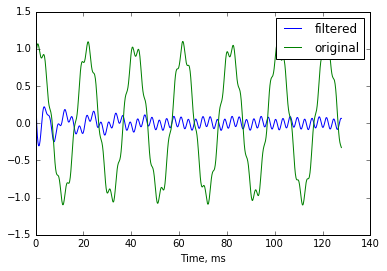

In [93]:
t_s = 1 / F_S
time = t_s * arange(1024)
y = sin(2*pi*50*time+pi/3) + 0.1 * sin(2*pi*329*time)
y_filtered = lfilter(b,a,y)
plt.plot(time*1000, y_filtered)
plt.plot(time*1000,y)
plt.xlabel("Time, ms")
plt.legend(["filtered", "original"])
plt.show()

## Фильтр для 5й струны

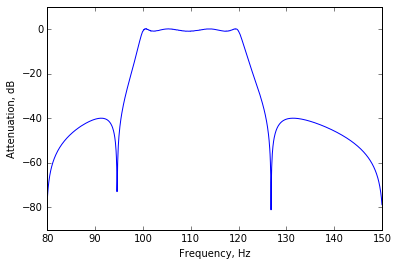

In [94]:
from numpy import array
F_S = 8000
F_NY = F_S/2 # Nyquist frequency
F0 = 110 #
W = 10 #Hz it's two steps
Fp = array([F0-W,F0+W])
Fs = array([F0-2*W, F0+2*W])
Wp = Fp/F_NY # end of passband, normalized frequency
Ws = Fs/F_NY # start of the stopband, normalized frequency 
Rp = 1    # passband maximum loss (gpass)
As = 40      # stoppand min attenuation (gstop)
# The ellip filter design
# output='ba' 'cause we need that form for freqz
b, a = fd.iirdesign(Wp, Ws, Rp, As, ftype='ellip', output = 'ba')

(w, H) = freqz(b,a, worN=6*10**4)

Hn = 20 * log10(abs(H))
freq = w / (2*pi) * F_S
ulim = argmax(freq > 150)
llim = argmax(freq > 80)
plt.plot(freq[llim:ulim],Hn[llim:ulim])
plt.xlabel("Frequency, Hz")
plt.ylabel("Attenuation, dB")
plt.show()